# Naive approach xgboost

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

# drop id
df_train.drop('id', axis=1, inplace=True)

df_train['date'] = pd.to_datetime(df_train['date'])

df_train.head(10)

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [10]:
# split date into year, month, day
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day

# drop date
df_train_0 = df_train.drop('date', axis=1)

# one-hot encoding of 'country', 'store', 'product' columns
#df_train = pd.get_dummies(df_train, columns=['country', 'store', 'product'])


df_train_0['country'] = df_train_0['country'].astype('category')
df_train_0['store'] = df_train_0['store'].astype('category')
df_train_0['product'] = df_train_0['product'].astype('category')

df_train_0.head(10)

,country,store,product,num_sold,year,month,day
0,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,1
1,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,1
2,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,2017,1,1
3,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,2017,1,1
4,Argentina,Kaggle Learn,Using LLMs to Write Better,49,2017,1,1
5,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88,2017,1,1
6,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98,2017,1,1
7,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14,2017,1,1
8,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83,2017,1,1
9,Argentina,Kaggle Store,Using LLMs to Write Better,69,2017,1,1


In [11]:
df_train_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   country   136950 non-null  category
 1   store     136950 non-null  category
 2   product   136950 non-null  category
 3   num_sold  136950 non-null  int64   
 4   year      136950 non-null  int32   
 5   month     136950 non-null  int32   
 6   day       136950 non-null  int32   
dtypes: category(3), int32(3), int64(1)
memory usage: 3.0 MB


In [16]:
# split into train and validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, median_absolute_error

import xgboost as xgb

results_mse = []
results_mae = []


for train_index, val_index in TimeSeriesSplit(n_splits=5).split(df_train_0):
    X_train = df_train_0.iloc[train_index]
    y_train = df_train_0.iloc[train_index]['num_sold']

    X_val = df_train_0.iloc[val_index]
    y_val = df_train_0.iloc[val_index]['num_sold']
      
    model = xgb.XGBRegressor(tree_method="gpu_hist", enable_categorical=True)
    model.fit(X_train, y_train)

    # evaluate on validation set
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = median_absolute_error(y_val, y_pred)
    
    results_mse.append("%.2f" % mse)
    results_mae.append("%.2f" % mae)
    del model

print(f"Mean squared error for each split: | {' | '.join(results_mse)} |")
print(f"Median absolute error for each split: | {' | '.join(results_mae)} |")

Mean squared error for each split: | 74.64 | 27.09 | 15.69 | 33.75 | 109.78 |
Median absolute error for each split: | 0.24 | 0.20 | 0.15 | 0.13 | 0.19 |


In [13]:
# train on full data
X_train = df_train_0.drop('num_sold', axis=1)
y_train = df_train_0['num_sold']

model = xgb.XGBRegressor(tree_method="gpu_hist", enable_categorical=True)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

C:\Users\Wiktor\AppData\Local\Temp\ipykernel_18984\2450452641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['date'] = pd.to_datetime(X_val['year'].astype(str) + '-' + X_val['month'].astype(str) + '-' + X_val['day'].astype(str))
C:\Users\Wiktor\AppData\Local\Temp\ipykernel_18984\2450452641.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.sort_values(by='date', inplace=True)


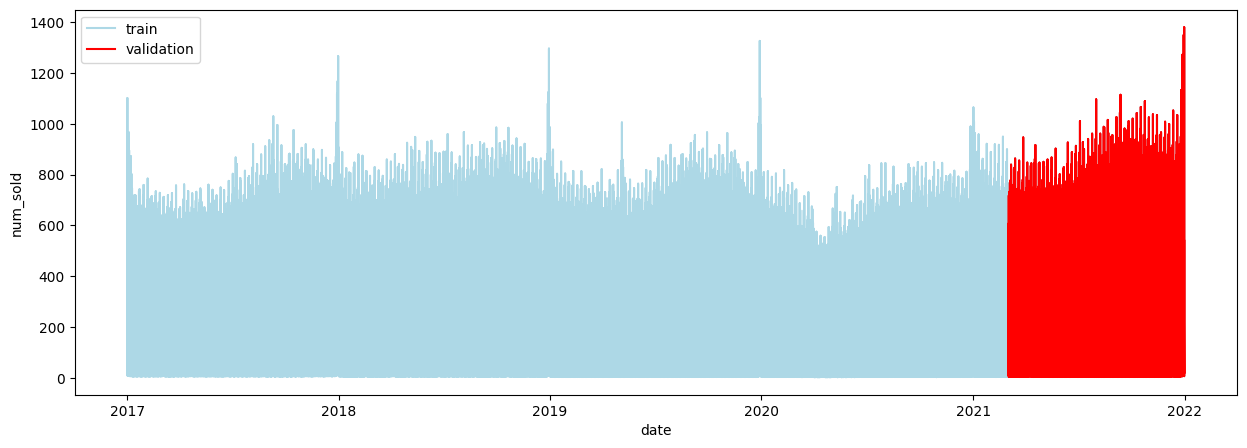

In [14]:
X_train['date'] = pd.to_datetime(X_train['year'].astype(str) + '-' + X_train['month'].astype(str) + '-' + X_train['day'].astype(str))
X_val['date'] = pd.to_datetime(X_val['year'].astype(str) + '-' + X_val['month'].astype(str) + '-' + X_val['day'].astype(str))

# sort by date
X_train.sort_values(by='date', inplace=True)
X_val.sort_values(by='date', inplace=True)

# plot 'num_sold' vs 'date'
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(X_train['date'], y_train, label='train', color='lightblue')
ax.plot(X_val['date'], y_val, label='validation', color='red')

ax.set_xlabel('date')
ax.set_ylabel('num_sold')

ax.legend()
plt.show()

In [15]:
df_val['prediction'] = model.predict(df_val[['year', 'month', 'day', 'country', 'store', 'product']])
df_val['prediction'] = df_val['prediction'].astype(int)
df_val

NameError: name 'df_val' is not defined

In [ ]:
# test 

df_test = pd.read_csv(data_path + "test.csv")
df_test_0 = df_test.drop('id', axis=1)
df_test_0['date'] = pd.to_datetime(df_test_0['date'])

df_test_0['year'] = df_test_0['date'].dt.year
df_test_0['month'] = df_test_0['date'].dt.month
df_test_0['day'] = df_test_0['date'].dt.day


df_test_0['country'] = df_test_0['country'].astype('category')
df_test_0['store'] = df_test_0['store'].astype('category')
df_test_0['product'] = df_test_0['product'].astype('category')

# predict for test set

df_test_0['prediction'] = model.predict(df_test_0[['year', 'month', 'day', 'country', 'store', 'product']])
df_test_0['prediction'] = df_test_0['prediction'].astype(int)
df_test_0

In [ ]:
# join df_test with df_test_0 on date, country, store and product

df_test_0['date'] = df_test_0['date'].astype(str)
df_test['date'] = df_test['date'].astype(str)

df_test_1 = pd.merge(df_test, df_test_0, on=['date', 'country', 'store', 'product'], how='outer')
df_test_1

In [ ]:
df_test_1['num_sold'] = df_test_1['prediction']
df_test_1[['id', 'num_sold']].to_csv('first_submission.csv', index=False)